## ON THE PLURALITY OF GRAPHS

Small _network-based_ playground to create sample graphs on which to play Lewis signaling games ;-)

### Installation and imports

_First make sure we have networkx updated as v 2.0 had some API changes and we want to avoid troubles_

In [1]:
# ! pip install networkx --upgrade

_Install also the nice powerlaw package if we want to run also the power law analysis_

In [2]:
# ! pip install powerlaw

In [19]:
import networkx as nx
import powerlaw
import matplotlib.pyplot as plt
import numpy as np
from random import choice

In [4]:
%matplotlib inline

### Simulation variables

In [5]:
N_NODES = 1000
NETWORK_PARAMS = dict()

Settings for barabasi-albert graph - scale free with pref attachment

https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model

https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html?highlight=barabasi_albert_graph#networkx.generators.random_graphs.barabasi_albert_graph

In [6]:
NETWORK_PARAMS['barabasi'] = [N_NODES, 5] 

Settings for Erdős–Rényi model - random graph

https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model

https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html?highlight=erdos_renyi_graph#networkx.generators.random_graphs.erdos_renyi_graph

In [7]:
NETWORK_PARAMS['erdos'] = [N_NODES, 0.15]

Settings for the Watts–Strogatz - "small-world graph", including short average path lengths and high clustering (six-degrees of separation kind of thing) 

https://en.wikipedia.org/wiki/Watts%E2%80%93Strogatz_model

https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html?highlight=watts_strogatz_graph#networkx.generators.random_graphs.watts_strogatz_graph

In [8]:
NETWORK_PARAMS['watts'] = [N_NODES, 3, 0.1]

### Some graph / chart / stats utils functions

In [9]:
def draw_network(nx_graph, node_color='black', node_size=100, width=3):
    options = {
        'node_color': node_color,
        'node_size': node_size,
        'width': width
    }
    nx.draw(nx_graph, with_labels=True, font_weight='bold', **options)
    plt.show()

In [10]:
def get_all_degrees(nx_graph):
    return [d for n, d in nx_graph.degree()]

In [11]:
def plot_degree_distribution(nx_graph, bins=20, label='My Graph'):
    """
    Convenient function that retrieves all degree and bins them to visualize distribution
    """ 
    all_degrees = get_all_degrees(nx_graph)
    plt.hist(all_degrees, bins=bins)
    plt.title("Degree Frequency Distribution for {}".format(label))
    plt.show()

In [12]:
def fit_power_law_to_data(data, alternative_distribution='lognormal', target_file=None):
    """
    Use fantastic powerlaw package based on SFI paper -> https://arxiv.org/pdf/1305.0215.pdf
    """
    # fit a discrete powerlaw here
    results = powerlaw.Fit(data, discrete=True)
    alpha = results.power_law.alpha
    xmin = results.power_law.xmin
    R, p = results.distribution_compare('power_law', alternative_distribution, normalized_ratio=True)
    fig2 = results.plot_ccdf(color='b', linewidth=2)
    results.power_law.plot_ccdf(color='r', linestyle='--', ax=fig2)
    # save to disk if a path is specified
    if target_file:
        fig2.figure.savefig(target_file)
    
    return alpha, xmin, R, p, results.truncated_power_law.alpha

### Interlude: Test out networkx general functions

First, test out networkx generation capabilities on two types of graphs

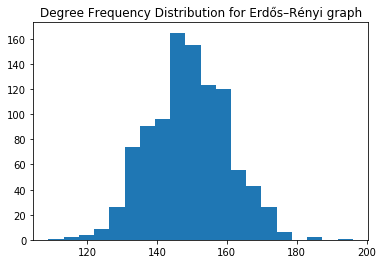

In [13]:
# generate graph with params
er = nx.erdos_renyi_graph(*NETWORK_PARAMS['erdos'])
# plot distribution
plot_degree_distribution(er, bins=20, label='Erdős–Rényi graph')

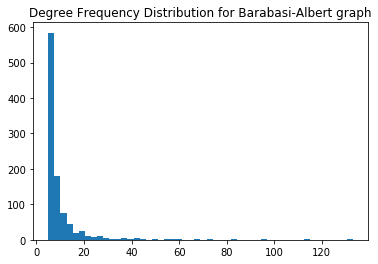

In [14]:
# generate graph with params
ba = nx.barabasi_albert_graph(*NETWORK_PARAMS['barabasi'])
# plot distribution
plot_degree_distribution(ba, bins=50, label='Barabasi-Albert graph')
# fit a powerlaw

_Check degree distribution using the nice powerlaw package from http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0085777_

Calculating best minimal value for power law fit
/Users/jacopotagliabue/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/Users/jacopotagliabue/anaconda3/lib/python3.6/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


Alpha value for p-law: 2.7232458325499582
Loglikelihood ratio between the two candidate distributions is 5.485721387452518, favoring powerlaw
The significance value for the ratio is 4.1178547967911066e-08


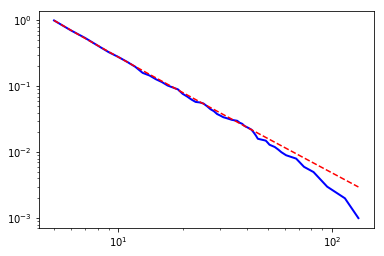

In [15]:
# check goodness of fit against a natural candidate -> see https://arxiv.org/pdf/1305.0215.pdf
alternative_distribution = 'exponential'
alpha, xmin, R, p, t_alpha = fit_power_law_to_data(get_all_degrees(ba), alternative_distribution=alternative_distribution)
print("Alpha value for p-law: {}".format(alpha))
print("Loglikelihood ratio between the two candidate distributions is {}, favoring {}".format(R,
                                                                                             'powerlaw' if R > 0.0 else alternative_distribution))
print("The significance value for the ratio is {}".format(p))

_As expected, the BA network is well-represented by the power-law distribution for degrees_

Finally, not exactly fancy, but try to draw a small graph in case we need some charts later on...

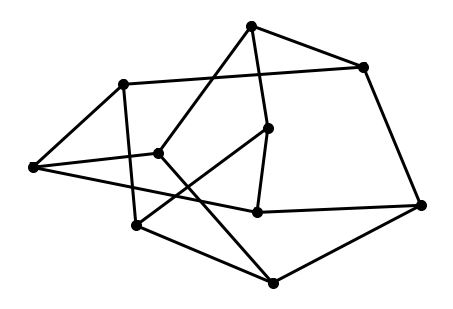

In [16]:
g = nx.petersen_graph()
draw_network(g)

### Generating networks and sampling strategies

In [73]:
def pick_random_node(nx_graph):
    return choice(list(nx_graph.nodes))

In [74]:
def get_network_by_type_and_settings(network_type, network_settings):
    """
    Network type must be one of: erdos, watts, barabasi
    """
    if network_type == 'erdos':
        return nx.erdos_renyi_graph(*network_settings)
    elif network_type == 'watts':
        return nx.watts_strogatz_graph(*network_settings)
    elif network_type == 'barabasi':
        return nx.barabasi_albert_graph(*network_settings)
    else:
        raise Exception("Unknown type: {}".format(network_type))

In [75]:
def calculate_network_centrality(nx_graph, centrality_metrics):
    """
    centrality_metrics must be one of 'degree', 'pagerank', 'betweeness'
    
    return type is always a dict(node->measure of centrality)
    """
    if centrality_metrics == 'degree':
        return nx.degree_centrality(nx_graph)
    elif centrality_metrics == 'betweeness':
        return nx.betweenness_centrality(nx_graph)
    elif centrality_metrics == 'pagerank':
        return nx.pagerank_numpy(nx_graph)
    else:
        raise Exception("Unknown metrics: {}".format(centrality_metrics))

In [76]:
# list options
NETWORK_TOPOLOGIES = ['erdos', 'watts', 'barabasi']
# pick one randomly here
current_topology = choice(NETWORK_TOPOLOGIES)
# list options
CENTRALITY_MEASURES = ['degree', 'pagerank', 'betweeness']
# pick one randomly here
current_centrality_measure = choice(CENTRALITY_MEASURES)
print("Chosen topology is: {}, with params: {} and centrality: {}".format(current_topology, 
                                                                          NETWORK_PARAMS[current_topology],
                                                                          current_centrality_measure))

Chosen topology is: barabasi, with params: [1000, 5] and centrality: betweeness


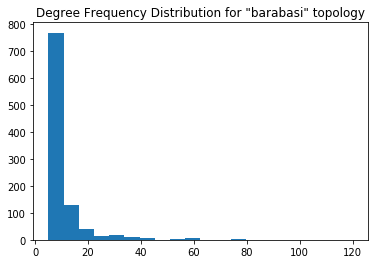

0 0.05192671484742907
1 0.027865702998640874
2 0.052405538641357066
3 0.0076813087103280876
4 0.02039071136774053
5 0.08211025019532313
6 0.10253970152454991
7 0.04640974467051477
8 0.014363527791577785
9 0.03297165713885735


In [77]:
# generate network
current_network = get_network_by_type_and_settings(current_topology, NETWORK_PARAMS[current_topology])
# plot distribution
plot_degree_distribution(current_network, bins=20, label='"{}" topology'.format(current_topology))
# get centrality
node_2_centrality = calculate_network_centrality(current_network, current_centrality_measure)
# print out some sample centrality values for debug
for n in list(node_2_centrality.keys())[:10]:
    print(n, node_2_centrality[n])

In [81]:
def sample_neighbors_of_node(nx_graph, source_node, topn=1):
    """
    Get neighboring nodes and then return N random ones up until the topn
    """
    neighbors = [n for n in nx_graph.neighbors(source_node)]
    # we shouldn't have disconnected graphs, but check to avoid weird things..
    assert len(neighbors) > 0
    
    # check N are not less than the requested amount
    if topn >= len(neighbors):
        return neighbors
    
    # return random subset
    return np.random.choice(neighbors, topn, replace=False)

In [82]:
def sample_pair_randomly(nx_graph, verbose=False):
    first_node = pick_random_node(nx_graph)
    second_node = sample_neighbors_of_node(nx_graph, first_node)[0]
    if verbose:
        print("Sampled {} and {}".format(first_node, second_node))
    
    return (first_node, second_node)

In [83]:
def sample_pair_through_centrality(nx_graph):
    first_node = pick_random_node(nx_graph)
    second_node = sample_neighbors_of_node(nx_graph, first_node)[0]
    
    return (first_node, second_node)

_Now test all the function return data as expected running them with different configs and network_

In [84]:
sample_pair_randomly(current_network)

(88, 243)

Finally show how to apply the "Friendship paradox" to sample highly central individuals without assuming a bird-eye of the entire network and all the centrality values..

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2939797/ 
    
https://en.wikipedia.org/wiki/Friendship_paradox

In [ ]:
def sample_pair_through_friends():
    
    return 